# 1/ Context
- Ops's long term target is reaching 95% acceptance rate
- However, existing actions (reward policies, hot promo, driver acquisition,...) do not have such huge impacts to enhance the acceptance rate value. <br>
=> Try to use a different approach which is predicting unaccepted orders to have proper action then (auto assign, push incentives for these orders,..) to ensure that there will be less unaccepted orders

In [2]:
from fbprophet import Prophet

RuntimeError: 'list' must be None or a list, not <class 'str'>

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Import basic packages
import pandas as pd 
import datetime as dt
import numpy as np
import os
import pandas_gbq
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime as dt

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 2/ Execution

- Models used: Logistics regression, Random Forest Classifier
- **Data input**: Orders within 1 week (22-29/07/2019) in HAN
- Feature explaination: <br>
    **Raw features:** id, order_time, cancel_comment, accept_time, service_id, hour, dow, total_fee, distacnce, total_cod, path_length<br>
    **Other features:** <br>
    + lat_0: pick up lat
    + lng_0: pick up lng
    + lat_1: drop off lat
    + lng_1: drop off lng
    + district_0: pick up district
    + district_1: drop off district
    + surge: surge multiplier for each order
    + tip : 0 if there was no tipping, else 1
    + promo: 0 if there was no promo code for this order, else 1
    + cancel_duration: cancel time - order time 
    + sup_id_around: the number of supplier who was online within 1km radius around 1 order and within 5 minute from order time
    + order_around: the number of order which appreared around a order within 1km radius and may have impact on whether a order would be accepted or not
    <br>
 **Unaccepted orders definition:**<br>
 Unaccepted orders here include _**auto cancelled orders**_ and _**cancel by user orders which has cancel duration >= 4 minutes**_

## Data extract

In [3]:
# thêm feature về quận nhận hàng , promo code, sai cod, them so diem giao...
query = """

with sample as(
select id, order_time, create_time, cancel_comment, accept_time, service_id,extract( hour from order_time) as hour, extract( dayofweek from order_time) as dow, total_fee, status,
cast(json_extract(path, "$[1].lat") as float64) as lat_1, 
cast(json_extract(path, "$[1].lng") as float64) as lng_1,
cast(json_extract(path, "$[0].lng") as float64) as lng_0,
cast(json_extract(path, "$[0].lat") as float64) as lat_0,
distance, json_extract(_extra_props, "$.surcharge") as surge,
timestamp_diff(timestamp_add(cancel_time, interval 7 hour), create_time, second) as cancel_duration,
case when promo_code is not null then 1 else 0 end as promo,
case when requests like '%TIP%' then 1 else 0 end as tip,
path_length,
timestamp_diff(accept_time, order_time, second)  as acc_duration,
case when accept_time is not null then accept_time
     when accept_time is null then timestamp_add(cancel_time, interval 7 hour) end as end_time
from ahamove_archive.order2019
where city_id = 'SGN'
and service_id in ('SGN-BIKE')
and date(order_time) >= date('2019-08-26')
and date(order_time) < date('2019-09-02')
)

,sample1 as(
select *,timestamp_diff(end_time,create_time, second)  as end_duration
from sample)

,district as(
select s.*,name_vn as district_1 from sample1 s

inner join ahamove_archive.admin_areas a
on ST_CONTAINS(a.geometry, ST_GEOGPOINT(lng_1, lat_1))
where level ='3'
)

,district0 as(
select d.*,name_vn as district_0 from district d
inner join ahamove_archive.admin_areas a
on ST_CONTAINS(a.geometry, ST_GEOGPOINT(lng_0, lat_0))
where level ='3'
)

select *,  case when accept_time is null then 1
            else 0 end as accepted
from district0




"""

In [4]:
df=pandas_gbq.read_gbq(query, 'aha-move',dialect='standard')

In [5]:
len(df)

90104

In [6]:
df = df.fillna(0)

In [7]:
df.head()

,id,order_time,create_time,cancel_comment,accept_time,service_id,hour,dow,total_fee,status,...,cancel_duration,promo,tip,path_length,acc_duration,end_time,end_duration,district_1,district_0,accepted
0,L9I457,2019-09-01 16:23:46,2019-09-01 16:23:46,0,2019-09-01 16:35:51,SGN-BIKE,16,1,30000.0,COMPLETED,...,0.0,0,0,2,725.0,2019-09-01 16:35:51,725,Quận Bình Thạnh,Quận 2,0
1,354TGD,2019-08-29 08:47:13,2019-08-29 08:47:13,0,2019-08-29 08:54:01,SGN-BIKE,8,5,69000.0,COMPLETED,...,0.0,0,0,2,408.0,2019-08-29 08:54:01,408,Quận Bình Thạnh,Quận 2,0
2,8U4YON,2019-09-01 08:32:12,2019-09-01 08:32:12,0,2019-09-01 08:35:16,SGN-BIKE,8,1,64000.0,COMPLETED,...,0.0,0,0,2,184.0,2019-09-01 08:35:16,184,Quận 2,Quận 2,0
3,6Z3VWH,2019-08-31 10:22:23,2019-08-31 10:22:23,0,2019-08-31 10:23:22,SGN-BIKE,10,7,54000.0,COMPLETED,...,0.0,1,0,2,59.0,2019-08-31 10:23:22,59,Quận 7,Quận 2,0
4,1TZJCE,2019-08-29 09:05:40,2019-08-29 09:05:40,0,2019-08-29 09:06:52,SGN-BIKE,9,5,30000.0,COMPLETED,...,0.0,0,0,2,72.0,2019-08-29 09:06:52,72,Quận 2,Quận 2,0


In [8]:
df.groupby('accepted').size()

accepted
0    80843
1     9261
dtype: int64

In [9]:
df.loc[df['end_duration']>600,'accepted']=1

In [11]:
df.groupby('accepted').size()

accepted
0    77939
1    12165
dtype: int64

In [12]:
df_drop=df[(df['cancel_duration']<60)&(df['cancel_duration'] != 0)][['id','cancel_duration','cancel_comment','accepted']]

In [13]:
df_drop.groupby('cancel_comment').size().sort_values(0,ascending=False).head()

cancel_comment
Cancel by User                                    2421
I selected wrong delivery address                  206
Cancel by User (Input incorrect order details)      84
Duplicated order                                    33
Driver was too far from pick-up location            32
dtype: int64

In [14]:
df = df[(df['cancel_duration']>=60)|(df['cancel_duration'] == 0)]

In [15]:
df.groupby('accepted').size()

accepted
0    77318
1     9872
dtype: int64

In [16]:
df['acc_duration'] = df['acc_duration'].fillna(10000)

# df['acc_duration'] = [i for i in df['acc_duration'] if i is not None]

In [17]:
# df['acc_duration'][df['acc_duration'] != 10000]

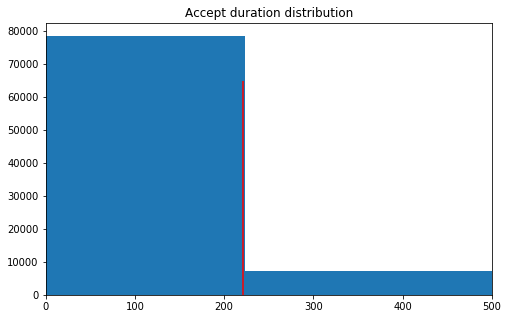

In [18]:
plt.figure(figsize= (8,5))
plt.hist(df['acc_duration'], bins = 50)
plt.xlim(0,500)
plt.vlines(np.quantile(df['acc_duration'][df['acc_duration'] != 10000], 0.90), ymin = 0, ymax = 65000, colors= 'r')
plt.title('Accept duration distribution')
plt.show()

In [19]:
print('Percentile 90 of accept duration is ' + str(np.quantile(df['acc_duration'][df['acc_duration'] != 10000], 0.90)/60)+ ' minutes')

Percentile 90 of accept duration is 3.683333333333333 minutes


In [20]:
len(df)

87190

In [21]:
df[df['end_duration'] > 600]

,id,order_time,create_time,cancel_comment,accept_time,service_id,hour,dow,total_fee,status,...,cancel_duration,promo,tip,path_length,acc_duration,end_time,end_duration,district_1,district_0,accepted
0,L9I457,2019-09-01 16:23:46,2019-09-01 16:23:46,0,2019-09-01 16:35:51,SGN-BIKE,16,1,30000.0,COMPLETED,...,0.0,0,0,2,725.0,2019-09-01 16:35:51,725,Quận Bình Thạnh,Quận 2,1
23,GYBQ0Q,2019-08-30 13:57:04,2019-08-30 13:57:04,0,2019-08-30 14:12:43,SGN-BIKE,13,6,23000.0,COMPLETED,...,0.0,1,0,2,939.0,2019-08-30 14:12:43,939,Quận 5,Quận 11,1
30,N3A5BZ,2019-08-28 15:57:36,2019-08-28 15:57:36,0,2019-08-28 16:16:43,SGN-BIKE,15,4,26000.0,COMPLETED,...,0.0,0,0,2,1147.0,2019-08-28 16:16:43,1147,Quận 8,Quận 11,1
48,2RDWCB,2019-08-31 14:56:05,2019-08-31 14:56:05,0,2019-08-31 15:08:42,SGN-BIKE,14,7,33000.0,COMPLETED,...,0.0,0,0,2,757.0,2019-08-31 15:08:42,757,Quận 12,Quận Tân Phú,1
50,K3RBA6,2019-08-26 16:37:33,2019-08-26 16:37:33,0,2019-08-26 16:51:20,SGN-BIKE,16,2,23000.0,COMPLETED,...,0.0,0,0,2,827.0,2019-08-26 16:51:20,827,Quận Tân Bình,Quận Tân Phú,1
52,GL6JWG,2019-08-29 11:35:10,2019-08-29 11:35:10,0,2019-08-29 11:47:34,SGN-BIKE,11,5,28000.0,COMPLETED,...,0.0,1,0,2,744.0,2019-08-29 11:47:34,744,Quận 12,Quận Tân Phú,1
113,R32Q3X,2019-08-29 13:04:10,2019-08-29 13:04:10,0,2019-08-29 13:24:34,SGN-BIKE,13,5,26000.0,COMPLETED,...,0.0,0,0,2,1224.0,2019-08-29 13:24:34,1224,Quận 5,Quận 5,1
114,OTZHXQ,2019-08-27 13:47:49,2019-08-27 13:47:49,0,2019-08-27 13:59:44,SGN-BIKE,13,3,33000.0,COMPLETED,...,0.0,1,0,2,715.0,2019-08-27 13:59:44,715,Quận 7,Quận 5,1
120,IY2E0I,2019-08-30 15:52:48,2019-08-30 15:52:48,0,2019-08-30 16:07:12,SGN-BIKE,15,6,31000.0,COMPLETED,...,0.0,1,0,2,864.0,2019-08-30 16:07:12,864,Quận 3,Quận 8,1
121,NM7D8S,2019-08-27 17:52:24,2019-08-27 17:52:24,0,2019-08-27 18:11:09,SGN-BIKE,17,3,23000.0,COMPLETED,...,0.0,1,0,2,1125.0,2019-08-27 18:11:09,1125,Quận 8,Quận 5,1


Thus, I choose the threshold of 4 minutes to define unaccepted orders which is cancelled by user

In [22]:
# Lấy total cod từ pg
import pandas as pd
import psycopg2 as pg
import os
import logging
conn = pg.connect(os.getenv("dataprodution"))
try:
    cur = conn.cursor()
    cur.execute("""
    
    select id, extra ->> 'total_cod'  as total_cod from "order"
    where order_date >= '2019-08-12'
    and order_date < '2019-08-19'
    and service_id = 'SGN-BIKE'
     
    """)
    conn.commit()
    
    df_cod = pd.DataFrame(cur.fetchall(),columns = [desc[0] for desc in cur.description])

except:
    logging.exception('message')
    pass
finally:
    cur.close()
    conn.close()


In [23]:
df = pd.merge(df, df_cod, on = 'id', how = 'left')

In [24]:
df_final = df.copy()

In [25]:
len(df_final)

87190

In [26]:
# lấy số tài xế online xung quanh đơn hàng trong bán kính 1km và từ thời điểm order time đến order_time + 5 min
query = """with sample as(
select id, order_time, status, date( order_time) order_date,cast(json_extract(path,"$[0].lat") as float64) as order_lat, 
cast(json_extract(path,"$[0].lng") as float64) as order_lng
from ahamove_archive.order2019
where date(order_time) >= date('2019-08-12')
and date(order_time) < date('2019-08-15')
and service_id = 'SGN-BIKE')

,sup as(
SELECT distinct id, order_time, sup_id
FROM sample s  inner join ahamove_archive.supplier_location l 
on ST_DWITHIN(ST_GEOGPOINT(lng, lat) , ST_GEOGPOINT(order_lng, order_lat), 2000)
WHERE track_time <= order_time
and track_time >= timestamp_sub(order_time, interval 15 minute)
and date(track_time) >= date('2019-08-12')
and date(track_time) < date('2019-08-15')
and l.status is null
and lat <= 90)

select id, count(distinct sup_id) as sup_id
from sup group by 1
 """
# try to run at night

In [27]:
df_driver4_1 =pandas_gbq.read_gbq(query, 'aha-move',dialect='standard')

In [29]:
query = """with sample as(
select id, order_time, status, date( order_time) order_date,cast(json_extract(path,"$[0].lat") as float64) as order_lat, 
cast(json_extract(path,"$[0].lng") as float64) as order_lng
from ahamove_archive.order2019
where date(order_time) >= date('2019-08-15')
and date(order_time) < date('2019-08-19')
and service_id = 'SGN-BIKE')

,sup as(
SELECT distinct id, order_time, sup_id
FROM sample s  inner join ahamove_archive.supplier_location l 
on ST_DWITHIN(ST_GEOGPOINT(lng, lat) , ST_GEOGPOINT(order_lng, order_lat), 2000)
WHERE track_time <= order_time
and track_time >= timestamp_sub(order_time, interval 15 minute)
and date(track_time) >= date('2019-08-15')
and date(track_time) < date('2019-08-19')
and l.status is null
and lat <= 90)

select id, count(distinct sup_id) as sup_id
from sup group by 1
 """

In [30]:
df_driver4_2 =pandas_gbq.read_gbq(query, 'aha-move',dialect='standard')

In [31]:
query = """with sample as(
select id, order_time, status, date( order_time) order_date,cast(json_extract(path,"$[0].lat") as float64) as order_lat, 
cast(json_extract(path,"$[0].lng") as float64) as order_lng
from ahamove_archive.order2019
where date(order_time) >= date('2019-08-12')
and date(order_time) < date('2019-08-19')
and service_id = 'SGN-BIKE')

,sup as(
SELECT distinct id, order_time, sup_id
FROM sample s  inner join ahamove_archive.supplier_location l 
on ST_DWITHIN(ST_GEOGPOINT(lng, lat) , ST_GEOGPOINT(order_lng, order_lat), 2000)
WHERE track_time <= order_time
and track_time >= timestamp_sub(order_time, interval 6 minute)
and date(track_time) >= date('2019-08-12')
and date(track_time) < date('2019-08-19')
and l.status is null
and lat <= 90)

select id, count(distinct sup_id) as sup_id
from sup group by 1
 """

In [32]:
# df_driver4_3 =pandas_gbq.read_gbq(query, 'aha-move',dialect='standard')

In [33]:
df_driver4 = pd.concat([df_driver4_2, df_driver4_1])

In [34]:
len(df_driver4)

88239

In [35]:
# lấy số đơn hàng chưa được accept xung quanh đơn hàng trong bán kính 1km và từ thời điểm order time đến order_time + 5 min
query = """

with sample as(
select *, case when accept_time is not null then accept_time else cancel_time end as end_time from(
select id, order_time, status, date( order_time) order_date, accept_time, timestamp_add(cancel_time, interval 7 hour) as cancel_time,
cast(json_extract(path,"$[0].lat") as float64) as order_lat, 
cast(json_extract(path,"$[0].lng") as float64) as order_lng
from ahamove_archive.order2019
where date(order_time) >= date('2019-08-12')
and date(order_time) < date('2019-08-19')
and service_id = 'SGN-BIKE') 
)

,sample2 as(
select *, case when accept_time is not null then accept_time else cancel_time end as end_time from(
select id, accept_time, status, order_time, timestamp_add(cancel_time, interval 7 hour) as cancel_time, date( order_time) order_date,cast(json_extract(path,"$[0].lat") as float64) as lat, 
cast(json_extract(path,"$[0].lng") as float64) as lng
from ahamove_archive.order2019
where date(order_time) >= date('2019-08-12')
and date(order_time) < date('2019-08-19')
and service_id = 'SGN-BIKE') 
a
)


,sup as(
SELECT distinct s.id, s.order_time, s.end_time as base_accept, 
l.id as order_around, l.order_time as order_time_around, l.end_time as acc_time_around
FROM sample s  inner join sample2 l 
on ST_DWITHIN(ST_GEOGPOINT(lng, lat) , ST_GEOGPOINT(order_lng, order_lat), 1500)
WHERE lat <= 90
and l.order_time <= s.order_time
and l.end_time > s.order_time

and date(l.order_time) >= date('2019-08-12')
and date(l.order_time) < date('2019-08-19') )

select  id, count(distinct order_around) as order_around
from sup group by 1

"""


In [36]:
df_order_around = pandas_gbq.read_gbq(query, 'aha-move',dialect='standard')

In [37]:
df_order_around.head()

,id,order_around
0,2EBXV4,14
1,VVPZKP,18
2,FMK6VE,27
3,FPIXAM,14
4,KH3ZY1,19


In [38]:
len(df_order_around)

88184

In [39]:
df_order_around[df_order_around['id'] == 'SW1L5Q']

,id,order_around
3284,SW1L5Q,1


In [40]:
df_order_around['order_around'] = df_order_around['order_around'] - 1

In [41]:
# len(df_driver4)

In [42]:
df_final= pd.merge(df, df_driver4, on = 'id', how = 'left')

In [43]:
df_final = pd.merge(df_final, df_order_around, on = 'id', how = 'left')

In [44]:
len(df_final)

87190

Final data frame:

In [45]:
df_final.head()

,id,order_time,create_time,cancel_comment,accept_time,service_id,hour,dow,total_fee,status,...,path_length,acc_duration,end_time,end_duration,district_1,district_0,accepted,total_cod,sup_id,order_around
0,L9I457,2019-09-01 16:23:46,2019-09-01 16:23:46,0,2019-09-01 16:35:51,SGN-BIKE,16,1,30000.0,COMPLETED,...,2,725.0,2019-09-01 16:35:51,725,Quận Bình Thạnh,Quận 2,1,NaN,NaN,NaN
1,354TGD,2019-08-29 08:47:13,2019-08-29 08:47:13,0,2019-08-29 08:54:01,SGN-BIKE,8,5,69000.0,COMPLETED,...,2,408.0,2019-08-29 08:54:01,408,Quận Bình Thạnh,Quận 2,0,NaN,NaN,NaN
2,8U4YON,2019-09-01 08:32:12,2019-09-01 08:32:12,0,2019-09-01 08:35:16,SGN-BIKE,8,1,64000.0,COMPLETED,...,2,184.0,2019-09-01 08:35:16,184,Quận 2,Quận 2,0,NaN,NaN,NaN
3,6Z3VWH,2019-08-31 10:22:23,2019-08-31 10:22:23,0,2019-08-31 10:23:22,SGN-BIKE,10,7,54000.0,COMPLETED,...,2,59.0,2019-08-31 10:23:22,59,Quận 7,Quận 2,0,NaN,NaN,NaN
4,1TZJCE,2019-08-29 09:05:40,2019-08-29 09:05:40,0,2019-08-29 09:06:52,SGN-BIKE,9,5,30000.0,COMPLETED,...,2,72.0,2019-08-29 09:06:52,72,Quận 2,Quận 2,0,NaN,NaN,NaN


In [94]:
# df[df['id'] == 'PPXVIV']

In [95]:
# df_order_around[df_order_around['id'] == 'PPXVIV']

In [96]:
# df_final[(df_final['accepted'] == 0)]

Final data frame info:

In [46]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87190 entries, 0 to 87189
Data columns (total 29 columns):
id                 87190 non-null object
order_time         87190 non-null datetime64[ns]
create_time        87190 non-null datetime64[ns]
cancel_comment     87190 non-null object
accept_time        87190 non-null object
service_id         87190 non-null object
hour               87190 non-null int64
dow                87190 non-null int64
total_fee          87190 non-null float64
status             87190 non-null object
lat_1              87190 non-null float64
lng_1              87190 non-null float64
lng_0              87190 non-null float64
lat_0              87190 non-null float64
distance           87190 non-null float64
surge              87190 non-null object
cancel_duration    87190 non-null float64
promo              87190 non-null int64
tip                87190 non-null int64
path_length        87190 non-null int64
acc_duration       87190 non-null float64
end_time   

In [47]:
df_final[df_final['id'] == 'SW1L5Q']

,id,order_time,create_time,cancel_comment,accept_time,service_id,hour,dow,total_fee,status,...,path_length,acc_duration,end_time,end_duration,district_1,district_0,accepted,total_cod,sup_id,order_around


In [48]:
df_final['sup_id'] = df_final['sup_id'].fillna(0)

In [49]:
df_final['order_around'] = df_final['order_around'].fillna(0)

In [50]:
df_final['surge'] = df_final['surge'].fillna(1)

Loại bỏ data các đơn hàng cancelled before accepted & cancel duration <4 minutes

In [102]:
# df_final['accept_time'] = df_final['accept_time'].fillna(0)


In [103]:
# df_final =df_final[(df_final['accept_time'] != 0) & (df_final['cancel_duration'] <4)]

In [104]:
# df_final[df_final['accepted'] == 1]

# ---------------------------------------------------------

## Data manipulation

In [52]:
df_final = df_final.drop_duplicates()

In [53]:
len(df_final)

87190

#### Elimiate some districts locating outside of Hanoi

 Drop off districts appeared in data input

In [54]:
from sklearn import preprocessing

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [55]:
# le = preprocessing.LabelEncoder()
# le.fit(df_final['district_0'].append(df_final['district_1']))
# le.classes_

# df_final['district_code_0']=le.transform(df_final['district_0'])
# df_final['district_code_1']=le.transform(df_final['district_1'])

In [56]:
# Quận drop off
df_final['district_1'].unique()

array(['Quận Bình Thạnh', 'Quận 2', 'Quận 7', 'Quận Gò Vấp', 'Quận 1',
       'Quận Thủ Đức', 'Quận Phú Nhuận', 'Quận 8', 'Quận 5', 'Quận 9',
       'Quận Bình Tân', 'Quận Tân Phú', 'Quận 12', 'Quận 3', 'Quận 11',
       'Quận Tân Bình', 'Quận 10', 'Quận 4', 'Quận 6', 'Huyện Bình Chánh',
       'Huyện Củ Chi', 'Thị xã Thuận An', 'Huyện Nhà Bè',
       'Thành phố Biên Hòa', 'Thành phố Thủ Dầu Một', 'Huyện Hóc Môn',
       'Huyện Cần Giuộc', 'Thị xã Dĩ An', 'Thị xã Tân Uyên',
       'Huyện Đức Hòa', 'Huyện Bến Lức', 'Huyện Nhơn Trạch',
       'Thị xã Bến Cát', 'Huyện Trảng Bom', 'Thị xã Long Khánh',
       'Huyện Phú Giáo', 'Thành phố Vũng Tàu', 'Thành phố Tây Ninh',
       'Huyện Bàu Bàng', 'Huyện Long Thành', 'Huyện Cần Giờ',
       'Huyện Trảng Bàng', 'Thành phố Tân An', 'Quận Long Biên',
       'Quận Hoàn Kiếm', 'Quận Nam Từ Liêm', 'Quận Ba Đình',
       'Quận Hai Bà Trưng', 'Quận Đống Đa', 'Quận Hoàng Mai',
       'Quận Cầu Giấy', 'Huyện Tân Thành', 'Huyện Cần Đước',
       'Huyện B

In [110]:
# df_final =df_final[df_final['district_1'].isin(['Quận Đống Đa','Quận Cầu Giấy','Quận Thanh Xuân','Quận Hai Bà Trưng',
#                            'Quận Hoàng Mai','Quận Ba Đình','Quận Nam Từ Liêm','Quận Hoàn Kiếm','Quận Hà Đông','Quận Tây Hồ',
#                            'Quận Bắc Từ Liêm','Quận Long Biên','Huyện Thanh Trì','Huyện Hoài Đức','Huyện Gia Lâm'
#                            'Huyện Đông Anh','Huyện Thanh Oai','Huyện Văn Giang','Huyện Đan Phượng','Huyện Thường Tín'])]

In [39]:
# df_final =df_final[df_final['district_1'].isin(['Quận 10', 'Quận Thủ Đức', 'Quận 1', 'Quận 8', 'Quận Bình Thạnh',
#        'Quận Tân Bình', 'Quận 11', 'Quận 7', 'Quận 9', 'Quận Bình Tân',
#        'Quận 3', 'Huyện Bình Chánh', 'Quận Gò Vấp', 'Quận Tân Phú',
#        'Quận 5', 'Quận Phú Nhuận', 'Thành phố Biên Hòa', 'Quận 6',
#        'Huyện Nhà Bè', 'Thị xã Dĩ An', 'Quận 2', 'Quận 4', 'Quận 12',
#        'Huyện Đức Hòa', 'Thị xã Thuận An', 'Huyện Hóc Môn',
#        'Huyện Củ Chi', 'Thành phố Thủ Dầu Một', 'Huyện Cần Giuộc', 'Huyện Nhơn Trạch',
#        'Thị xã Tân Uyên',
#          'Huyện Bến Lức', 'Thị xã Bến Cát'])]

Number of district count in data input

In [57]:
df_final.district_1.value_counts()

Quận 1                   9275
Quận Bình Thạnh          8396
Quận Tân Bình            8299
Quận 3                   5664
Quận 10                  5588
Quận Gò Vấp              5207
Quận Tân Phú             5103
Quận 7                   4711
Quận Phú Nhuận           4477
Quận Bình Tân            4100
Quận 5                   3501
Quận 2                   3372
Quận 8                   2739
Quận 4                   2600
Quận 11                  2406
Quận 12                  2382
Quận Thủ Đức             2282
Quận 6                   2109
Huyện Bình Chánh         1469
Quận 9                   1227
Huyện Hóc Môn             821
Huyện Nhà Bè              592
Thị xã Dĩ An              260
Thị xã Thuận An           189
Thành phố Biên Hòa        104
Thành phố Thủ Dầu Một      93
Huyện Củ Chi               77
Huyện Đức Hòa              20
Thị xã Tân Uyên            20
Huyện Cần Giuộc            16
Huyện Nhơn Trạch           12
Thị xã Bến Cát             12
Huyện Bến Lức              11
Quận Nam T

In [58]:
district_code = df_final.groupby('district_1').agg({'district_1':'count'}).rename(columns = {'district_1':'count'}).sort_values(by= 'count', ascending = False).reset_index()

In [59]:
district_code['district_code_1'] = [i for i in range(0, len(district_code))]

Switch district name from text type to numeric type to prepare for model fitting:

In [60]:
#District code quận drop off

district_code

,district_1,count,district_code_1
0,Quận 1,9275,0
1,Quận Bình Thạnh,8396,1
2,Quận Tân Bình,8299,2
3,Quận 3,5664,3
4,Quận 10,5588,4
5,Quận Gò Vấp,5207,5
6,Quận Tân Phú,5103,6
7,Quận 7,4711,7
8,Quận Phú Nhuận,4477,8
9,Quận Bình Tân,4100,9


In [61]:
service_code = pd.DataFrame.from_dict({'service_id': df['service_id'].unique(), 'service_code': range(0,len(df['service_id'].unique()))})

In [62]:
df_final = pd.merge(df_final, district_code, on = 'district_1', how = 'left')

In [63]:
# Quận pick up
district_code_0 = df_final.groupby('district_0').agg({'district_0':'count'}).rename(columns = {'district_0':'count_0'}).sort_values(by= 'count_0', ascending = False).reset_index()

In [64]:
district_code_0

,district_0,count_0
0,Quận Bình Thạnh,10383
1,Quận Tân Bình,9902
2,Quận 1,8586
3,Quận 10,7165
4,Quận 3,7103
5,Quận Phú Nhuận,6700
6,Quận Gò Vấp,5678
7,Quận Tân Phú,5662
8,Quận 5,3431
9,Quận Bình Tân,3312


In [65]:
district_code_0 = pd.merge(district_code, district_code_0,right_on='district_0', left_on='district_1', how = 'left' )

In [66]:
district_code_0['district_code_0'] = district_code_0['district_code_1'] 

In [67]:
district_code_0

,district_1,count,district_code_1,district_0,count_0,district_code_0
0,Quận 1,9275,0,Quận 1,8586.0,0
1,Quận Bình Thạnh,8396,1,Quận Bình Thạnh,10383.0,1
2,Quận Tân Bình,8299,2,Quận Tân Bình,9902.0,2
3,Quận 3,5664,3,Quận 3,7103.0,3
4,Quận 10,5588,4,Quận 10,7165.0,4
5,Quận Gò Vấp,5207,5,Quận Gò Vấp,5678.0,5
6,Quận Tân Phú,5103,6,Quận Tân Phú,5662.0,6
7,Quận 7,4711,7,Quận 7,3306.0,7
8,Quận Phú Nhuận,4477,8,Quận Phú Nhuận,6700.0,8
9,Quận Bình Tân,4100,9,Quận Bình Tân,3312.0,9


In [68]:
district_code_0 = district_code_0.to_csv('district_code_0.csv')

Do the same thing with pick up districts

In [51]:
district_code_0

,district_1,count,district_code_1,district_0,count_0,district_code_0
0,Quận 1,8927,0,Quận 1,7830.0,0
1,Quận Tân Bình,8379,1,Quận Tân Bình,10050.0,1
2,Quận Bình Thạnh,8244,2,Quận Bình Thạnh,9781.0,2
3,Quận 3,5513,3,Quận 3,7051.0,3
4,Quận 10,5433,4,Quận 10,7128.0,4
5,Quận Gò Vấp,5086,5,Quận Gò Vấp,5971.0,5
6,Quận Tân Phú,4863,6,Quận Tân Phú,5662.0,6
7,Quận 7,4639,7,Quận 7,3338.0,7
8,Quận Phú Nhuận,4570,8,Quận Phú Nhuận,6917.0,8
9,Quận Bình Tân,3761,9,Quận Bình Tân,2868.0,9


In [52]:
df_final = pd.merge(df_final, district_code_0[['district_0','district_code_0']], on = 'district_0', how = 'left')

In [53]:
df_final['total_cod'] = df_final['total_cod'].fillna(0)

In [54]:
df_final.head()

,id,order_time,create_time,cancel_comment,accept_time,service_id,hour,dow,total_fee,status,...,end_duration,district_1,district_0,accepted,total_cod,sup_id,order_around,count,district_code_1,district_code_0
0,ROQBDD,2019-08-12 10:51:15,2019-08-12 10:51:15,0,2019-08-12 10:51:36,SGN-BIKE,10,2,48000.0,COMPLETED,...,21,Quận 12,Quận Bình Tân,0,1290000,86.0,0.0,2356,15,9
1,XXYRMT,2019-08-12 20:06:54,2019-08-12 20:06:54,0,2019-08-12 20:16:20,SGN-BIKE,20,2,29000.0,COMPLETED,...,566,Quận 6,Quận Bình Tân,0,0,85.0,0.0,1963,17,9
2,MTS204,2019-08-16 09:06:35,2019-08-16 09:06:35,0,2019-08-16 09:06:43,SGN-BIKE,9,6,45000.0,COMPLETED,...,8,Quận Bình Tân,Quận Bình Tân,0,1035000,60.0,0.0,3761,9,9
3,2M58T9,2019-08-16 21:02:35,2019-08-16 21:02:35,0,2019-08-16 21:02:43,SGN-BIKE,21,6,29000.0,COMPLETED,...,8,Quận Bình Tân,Quận Bình Tân,0,1500000,59.0,0.0,3761,9,9
4,W8EPET,2019-08-14 16:27:40,2019-08-14 16:27:40,0,2019-08-14 16:27:55,SGN-BIKE,16,4,36000.0,COMPLETED,...,15,Quận 5,Quận Bình Tân,0,0,51.0,0.0,3459,10,9


In [55]:
df_final.to_csv('df_final_tracktime15.csv')

Create a new data frame used for model fitting with necessary features: 

In [56]:
df_use = df_final[['id','hour','dow','total_fee','total_cod','accepted','distance','district_code_0','district_code_1','surge','promo','tip','path_length','sup_id','district_1','district_0','order_around', 'acc_duration']]## 'sup_id'


In [128]:
# df_use[df_use['accepted'] == 1]

In [129]:
# df_use.head()

In [57]:
df_use['total_cod'] =df_use['total_cod'].apply(lambda x: float(x))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
df_use[df_use['sup_id']==0]

,id,hour,dow,total_fee,total_cod,accepted,distance,district_code_0,district_code_1,surge,promo,tip,path_length,sup_id,district_1,district_0,order_around,acc_duration
14579,3AZMAO,11,6,100000.0,1080000.0,1,19.21,18,3,0,0,0,2,0.0,Quận 3,Huyện Bình Chánh,0.0,0.0
18322,5ZELSN,10,2,23000.0,519000.0,1,3.47,19,19,0,0,0,2,0.0,Quận 9,Quận 9,0.0,0.0
21382,W4C43U,8,4,103000.0,0.0,1,19.89,18,18,0,0,0,2,0.0,Huyện Bình Chánh,Huyện Bình Chánh,0.0,0.0
24402,9BYNV5,10,2,90000.0,2550000.0,1,13.19,19,13,0,0,0,2,0.0,Quận 4,Quận 9,0.0,980.0
32426,O7PJR4,9,2,123000.0,628365.0,1,23.83,19,10,0,0,0,2,0.0,Quận 5,Quận 9,0.0,0.0
35649,3HAWRR,19,1,131000.0,0.0,1,25.47,27,2,0,0,0,2,0.0,Quận Bình Thạnh,Huyện Đức Hòa,0.0,0.0
38275,C7OJQF,8,4,98000.0,300000.0,1,18.98,18,1,0,0,0,2,0.0,Quận Tân Bình,Huyện Bình Chánh,0.0,0.0
39482,FGB51I,11,6,87000.0,1080000.0,1,16.63,18,3,0,0,0,2,0.0,Quận 3,Huyện Bình Chánh,0.0,0.0
42089,KX9A62,13,2,26000.0,0.0,1,4.59,18,12,0,0,0,2,0.0,Quận 8,Huyện Bình Chánh,0.0,0.0
49235,VS7EFC,14,7,26000.0,158000.0,1,4.48,18,18,0,0,0,2,0.0,Huyện Bình Chánh,Huyện Bình Chánh,0.0,672.0


In [131]:
df_use = df_use[df_use['sup_id'] != 0]

In [132]:
df_use['balance_rate'] = df_use['order_around']/df_use['sup_id']

In [133]:
# df_use = 
df_use[df_use['sup_id'] == 0]

,id,hour,dow,total_fee,total_cod,accepted,distance,district_code_0,district_code_1,surge,promo,tip,path_length,sup_id,district_1,district_0,order_around,acc_duration,balance_rate


In [134]:
df_use.head()

,id,hour,dow,total_fee,total_cod,accepted,distance,district_code_0,district_code_1,surge,promo,tip,path_length,sup_id,district_1,district_0,order_around,acc_duration,balance_rate
0,C4MOVI,15,6,26000.0,640000.0,0,0.00,0,0,1.13,0,0,2,158.0,Quận 1,Quận 1,0.0,9.0,0.000000
1,CUSRTG,15,5,35000.0,1500000.0,0,6.38,0,14,0,0,0,2,134.0,Quận 11,Quận 1,1.0,10.0,0.007463
2,99BLR2,15,5,23000.0,665000.0,0,1.42,0,8,0,0,0,2,109.0,Quận Phú Nhuận,Quận 1,19.0,4.0,0.174312
3,EC51H4,12,4,47000.0,580000.0,0,8.70,0,6,0,0,0,2,165.0,Quận Tân Phú,Quận 1,1.0,6.0,0.006061
4,8B3G55,14,3,34000.0,0.0,0,6.10,0,2,0,0,0,2,126.0,Quận Bình Thạnh,Quận 1,3.0,5.0,0.023810


In [135]:
# df_use[df_use['sup_id'] == 0][['id','accepted','distance','total_cod','district_0','district_1','sup_id','order_around']]

Features summary:

In [136]:
df_use.describe()

,hour,dow,total_fee,total_cod,accepted,distance,district_code_0,district_code_1,promo,tip,path_length,sup_id,order_around,acc_duration,balance_rate
count,85152.000000,85152.000000,85152.000000,8.515200e+04,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000,85152.000000
mean,13.536147,4.141394,41288.434799,5.559407e+05,0.116110,6.432869,5.890290,6.937253,0.148358,0.032882,2.170472,86.227476,2.323821,83.522560,0.026072
std,3.489998,1.898289,25612.108757,8.927405e+05,0.320359,4.667799,4.941153,5.764592,0.355457,0.178330,0.612620,40.414768,3.211033,266.406988,0.040751
min,0.000000,1.000000,23000.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,11.000000,3.000000,23000.000000,0.000000e+00,0.000000,3.370000,2.000000,2.000000,0.000000,0.000000,2.000000,55.000000,0.000000,8.000000,0.000000
50%,14.000000,4.000000,32000.000000,2.670000e+05,0.000000,5.330000,5.000000,6.000000,0.000000,0.000000,2.000000,88.000000,1.000000,18.000000,0.014706
75%,16.000000,6.000000,49000.000000,7.500000e+05,0.000000,8.390000,9.000000,11.000000,0.000000,0.000000,2.000000,116.000000,3.000000,67.000000,0.036496
max,23.000000,7.000000,720400.000000,2.554960e+07,1.000000,89.920000,29.000000,32.000000,1.000000,1.000000,10.000000,230.000000,33.000000,60317.000000,3.500000


In [137]:
df_use = df_use[(df_use['distance'] < 30) & (df_use['total_fee'] < 500000)]

### Variables standardization

** Standardize variables here

In [138]:
df_use['surge'] = df_use['surge'].apply(lambda x: float(x))

In [139]:
fee_mean = np.mean(df_use['total_fee'])
cod_mean = np.mean(df_use['total_cod'])
distance_mean = np.mean(df_use['distance'])
sup_id_mean = np.mean(df_use['sup_id'])
order_around_mean = np.mean(df_use['order_around'])
surge_mean = np.mean(df_use['surge'])

fee_stds = np.std(df_use['total_fee'])
cod_stds = np.std(df_use['total_cod'])
distance_stds = np.std(df_use['distance'])
sup_id_stds = np.std(df_use['sup_id'])
order_around_stds = np.std(df_use['order_around'])
surge_stds = np.std(df_use['surge'])

df_use['total_fee_norm'] = (df_use['total_fee'] - fee_mean)/fee_stds
df_use['cod_norm'] = (df_use['total_cod'] - cod_mean)/cod_stds
df_use['distance_norm'] = (df_use['distance'] - distance_mean)/distance_stds
df_use['sup_id_norm'] = (df_use['sup_id'] - sup_id_mean)/sup_id_stds
df_use['order_around_norm'] = (df_use['order_around'] - order_around_mean)/order_around_stds
df_use['surge_norm'] = (df_use['surge'] - surge_mean)/surge_stds

In [140]:
balance_rate_mean = np.mean(df_use['balance_rate'])
balance_rate_stds = np.std(df_use['balance_rate'])
df_use['balance_rate_norm'] = (df_use['balance_rate'] - balance_rate_mean)/balance_rate_stds

In [141]:
balance_rate_mean

0.02606405090564255

In [142]:
df_use['surge'] = df_use['surge'].apply(lambda x: float(x))

In [143]:
# plt.figure(figsize= (15,8))
# plt.subplot(2,2,1)
# plt.hist(df_use['hour'], bins = 24, alpha = 0.5)
# plt.hist(df_use[df_use['accepted'] == 1]['hour'], bins = 24, color= 'r', alpha = 0.5)

# plt.subplot(2,2,2)
# plt.hist(df_use['sup_id'], bins = 24, alpha = 0.5)
# plt.hist(df_use[df_use['accepted'] == 1]['sup_id'], bins = 80, color= 'r', alpha = 0.5)

# plt.subplot(2,2,3)
# plt.hist(df_use['total_cod'], bins = 50, alpha = 0.5)
# plt.hist(df_use[df_use['accepted'] == 1]['total_cod'], bins = 50, color= 'r', alpha = 0.5)
# plt.xlim(0,2000000)

# plt.subplot(2,2,4)
# plt.hist(df_use['total_fee'], bins = 80, alpha = 0.5)
# plt.hist(df_use[df_use['accepted'] == 1]['total_fee'], bins = 80, color= 'r', alpha = 0.5)
# plt.xlim(2000000,100000)
# plt.show()

In [144]:
# plt.figure(figsize= (15,8))
# plt.subplot(2,2,1)
# plt.hist(df_use['sup_id'], bins = 40)

# plt.subplot(2,2,2)
# plt.hist(df_use[df_use['accepted'] == 1]['sup_id'], bins = 40)
# # plt.xlim(0,200000)

# plt.show()

Chart below : Number of value between 0 and 1: <br>
0: accepted orders <br>
1: unaccepted orders <br>
_* based on the above definition of unaccepted order_

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


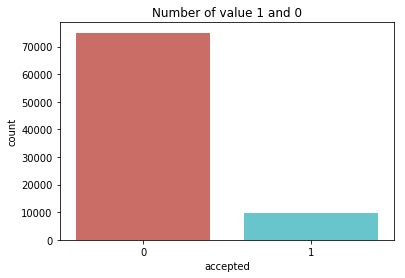

In [145]:
import seaborn as sns
sns.countplot(x = 'accepted', data = df_use, palette = 'hls')
plt.title('Number of value 1 and 0')
plt.show()

Specifically, there were 4327 values representing unaccepted orders and 100949 values representing accepted orders, equivalent to ~ 1:25 ratio

In [146]:
df_use.accepted.value_counts()

0    75015
1     9861
Name: accepted, dtype: int64

In [247]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84876 entries, 0 to 85265
Data columns (total 27 columns):
id                   84876 non-null object
hour                 84876 non-null int64
dow                  84876 non-null int64
total_fee            84876 non-null float64
total_cod            84876 non-null float64
accepted             84876 non-null int64
distance             84876 non-null float64
district_code_0      84876 non-null int64
district_code_1      84876 non-null int64
surge                84876 non-null float64
promo                84876 non-null int64
tip                  84876 non-null int64
path_length          84876 non-null int64
sup_id               84876 non-null float64
district_1           84876 non-null object
district_0           84876 non-null object
order_around         84876 non-null float64
acc_duration         84876 non-null float64
balance_rate         84876 non-null float64
total_fee_norm       84876 non-null float64
cod_norm             84876 non

In [248]:
df_use[df_use['accepted'] == 1][['id','accepted','district_0','district_code_0','district_1','total_fee','dow','total_cod','distance','surge','path_length','promo','tip','sup_id','order_around','balance_rate']]

,id,accepted,district_0,district_code_0,district_1,total_fee,dow,total_cod,distance,surge,path_length,promo,tip,sup_id,order_around,balance_rate
8,IPQJGH,1,Quận 1,0,Quận 7,26000.0,4,0.0,4.49,0.00,2,0,0,40.0,0.0,0.000000
18,30V51Z,1,Quận 1,0,Quận 10,26000.0,2,985000.0,4.46,0.00,2,1,0,48.0,2.0,0.041667
85,UWFELJ,1,Quận 1,0,Quận 7,35000.0,4,0.0,6.21,0.00,2,0,0,84.0,3.0,0.035714
145,KUVQKQ,1,Quận 1,0,Quận Bình Thạnh,23000.0,7,410000.0,3.35,0.00,2,0,0,87.0,10.0,0.114943
157,UJ2A9R,1,Quận 1,0,Quận Bình Thạnh,30000.0,5,285000.0,4.32,0.00,2,0,1,117.0,13.0,0.111111
196,T60PFV,1,Quận 1,0,Quận Bình Thạnh,44000.0,6,1275000.0,4.63,1.26,4,1,0,64.0,0.0,0.000000
200,D776BJ,1,Quận 1,0,Quận Bình Thạnh,29000.0,6,1658000.0,5.02,0.00,2,0,0,100.0,3.0,0.030000
207,EM06W8,1,Quận 6,17,Quận 10,33000.0,1,430000.0,5.90,0.00,2,1,0,48.0,1.0,0.020833
209,STX62E,1,Quận 6,17,Quận 8,23000.0,1,1220000.0,3.58,0.00,2,1,0,50.0,0.0,0.000000
215,ZXKO1F,1,Quận 6,17,Quận 8,26000.0,5,820000.0,4.57,0.00,2,0,0,99.0,4.0,0.040404


In [249]:
df_use[df_use['accepted'] == 1]['district_0'].value_counts()

Quận Tân Bình       1296
Quận Bình Thạnh     1095
Quận Phú Nhuận       879
Quận Gò Vấp          734
Quận 10              698
Quận 3               626
Quận Tân Phú         549
Quận 7               483
Quận Bình Tân        462
Quận 1               413
Quận 2               402
Quận Thủ Đức         352
Quận 12              339
Quận 8               300
Quận 9               223
Quận 11              206
Huyện Hóc Môn        191
Quận 5               177
Quận 6               151
Huyện Bình Chánh     121
Quận 4               113
Huyện Nhà Bè          43
Thị xã Thuận An        5
Thị xã Dĩ An           2
Huyện Cần Giuộc        1
Name: district_0, dtype: int64

### Recursive Feature Elimination

Whether we need to remove some features or not ?

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [251]:
X = df_use[['district_code_0','district_code_1','total_fee_norm','hour','dow','cod_norm','distance_norm','surge_norm','path_length','promo','tip','order_around_norm','sup_id_norm','balance_rate_norm']]
y = df_use['accepted']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.ravel())
print(rfe.support_)
print(rfe.ranking_)



[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [252]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.332715
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.074     
Dependent Variable:  accepted         AIC:              56506.9628
Date:                2019-08-30 11:56 BIC:              56637.8481
No. Observations:    84876            Log-Likelihood:   -28239.   
Df Model:            13               LL-Null:          -30491.   
Df Residuals:        84862            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
district_code_0    0.0047   0.0024   1.9821 0.0475  0.0001  0.0093
district_code_1    0.0257   0.0020  13.0168 0.0000  0

Since p_value << 0.05=> do not have to eliminate any features

**Features correlation matrix**

In [253]:
X = df_use[['district_code_0','district_code_1','total_fee_norm','hour','dow','cod_norm','distance_norm','surge_norm','path_length','promo','tip','order_around_norm','sup_id_norm','balance_rate_norm']]

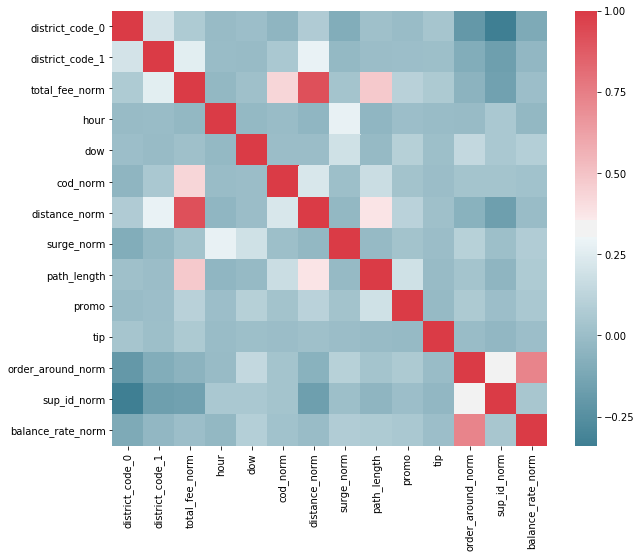

In [254]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# -----------------------------------------------------------

## Logistic regression 

### Split train & test set -  Model fitting

In [86]:
#'district_code_0',
X = df_use[['district_code_0','district_code_1','total_fee','dow','total_cod','distance','surge','path_length','promo','tip','sup_id','order_around']]
y = df_use['accepted']


In [87]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

In [88]:
# X_train

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [90]:
scaler=MinMaxScaler()
x_train=scaler.fit_transform(X_train)
x_test=scaler.transform(X_test)

In [91]:
alpha=[10**x for x in np.arange(-5, 40, dtype=float)]
# alpha

Cross validation

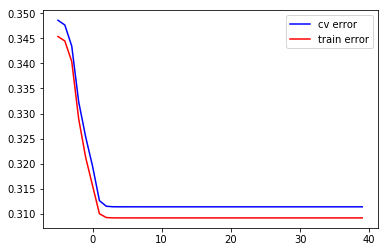

In [92]:
alpha=[10**x for x in np.arange(-5, 40, dtype=float)]
log_alpha=np.arange(-5,40)

cv_err=[]
train_err=[]
for a in alpha:
    clf=LogisticRegression(C=a, penalty='l2', class_weight='balanced')
    clf.fit(x_train, y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(x_train, y_train)
    
    predict_y=sig_clf.predict_proba(x_test)
    cv_err.append(log_loss(y_test, predict_y))
    
    predict_y=sig_clf.predict_proba(x_train)
    train_err.append(log_loss(y_train, predict_y))

plt.plot(log_alpha, cv_err, label='cv error', c='b')
plt.plot(log_alpha, train_err, label='train error', c='r')
plt.legend()
plt.show()

In [262]:
# alpha[np.argmin(cv_err)]

In [ ]:
# np.min(cv_err)

Model fitting:

In [263]:
# accuracy_score(y_test, clf.predict(x_test))

In [93]:
clf=LogisticRegression(C=alpha[np.argmin(cv_err)], penalty='l2', class_weight='balanced')
clf.fit(x_train, y_train)

LogisticRegression(C=1e+20, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# clf.coef_.T

In [94]:
# 'district_code_0',
columns=['district_code_0','district_code_1','dow','total_cod','distance','surge','path_length','sup_id','promo','tip','total_fee','order_around']

In [95]:
# np.array([columns[0:]]).T

In [96]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns[0:]]).T, clf.coef_.T)), columns=['feature', 'importance'])


In [97]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

Logistic regression model: Feature importances

In [10]:
feature_importance.sort_values(by='importance', ascending=False)

NameError: name 'feature_importance' is not defined

Model fitting ...

In [63]:
logreg = LogisticRegression(class_weight= 'balanced')
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
y_pred=logreg.predict(X_test)

In [78]:
df_prob=pd.DataFrame(logreg.predict_proba(X_test))
df_prob['predict'] = y_pred
df_prob['accepted'] = y_test.reset_index(drop=True)
df_prob

,0,1,predict,accepted
0,0.787605,0.212395,0,0
1,0.470467,0.529533,1,0
2,0.712500,0.287500,0,0
3,0.624837,0.375163,0,0
4,0.727024,0.272976,0,0
5,0.650813,0.349187,0,0
6,0.625305,0.374695,0,0
7,0.685573,0.314427,0,0
8,0.739744,0.260256,0,0
9,0.229326,0.770674,1,1


In [65]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

### Model evaluation: Logistic Regression

**Confusion matrix**

In [66]:
# Confusion matrix
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

,0,1
0,16314,6266
1,1112,1888


In [67]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7115715402658327
Precision: 0.23154280107922492
Recall: 0.6293333333333333


Result explaination: <br>
- In 1307 **actual unaccepted orders** in the test set, model could detect 1203 unaccepted orders, which accounts for 92.9% of  **actual unaccepted orders**. Only 104 **actual unaccepted orders** were predicted incorrectly to **accepted orders**. In this point of view, model works quite well

<br>
- But in over 30K **actual accepted orders**, there was only 70% of these orders ( equivalent to 21202 orders) being exactly predicted

<br>
Overall, model accuracy registers 70,9% => Still need to be improved

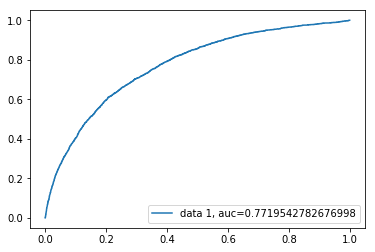

In [274]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Model's performance was quite good since auc ~ 0.9 because auc = 0.5 implies that model result does not have any meaning in prediction and auc = 1 means that model performs perfectly


# Save model

In [275]:
import pickle
filename = 'unaccepted_0s.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [276]:
load_model = pickle.load(open('unaccepted_0s.sav','rb'))

In [277]:
predict_result = load_model.predict(X_test)

In [278]:
predict_result

array([0, 0, 0, ..., 0, 1, 0])

In [279]:
X_test['predict'] = predict_result

In [ ]:
X_test['y_pred_1'] =y_pred


In [ ]:
y_pred_proba

#### Which feature ranges does the model work "well" in?

Target: Find the differences between features in case model predict correctly and incorrectly

In [ ]:
acc = pd.DataFrame(y_pred,y_test).rename(columns = {0:'y_pred','accepted':'y_test'}).reset_index()

In [ ]:
# acc.head()
# # acc[acc['accepted'] == 0]

In [ ]:
result = pd.concat([X_test.reset_index(), acc], axis= 1)

In [ ]:
# Wrong prediction df
miss_log = result[result['accepted'] != result['y_pred']]

In [ ]:
# miss_log.head()

In [ ]:
miss_log['join_on'] = miss_log['index']

In [ ]:
result['join_on'] = result['index']

In [ ]:
df_use['join_on'] = [i for i in range(0, len(df_use))]

In [ ]:
miss_log2 = pd.merge(miss_log[['join_on','y_pred']], df_use, on = 'join_on', how = 'left')

In [ ]:
result_log = pd.merge(result[['join_on','y_pred']], df_use, on = 'join_on', how = 'left')

In [ ]:
miss_log2['diff'] = miss_log2['y_pred'] - miss_log2['accepted']

In [ ]:
miss_log2[miss_log2['diff'] == 1][['id','y_pred','accepted','district_0','district_1','total_fee','dow','total_cod','distance','surge','path_length','promo','tip','sup_id','order_around','balance_rate']]

In [ ]:
result_log['diff'] = result_log['y_pred'] - result_log['accepted']

In [ ]:
con1 = (result_log['accepted'] == 0) & (result_log['y_pred'] == 1) ## 01 được accepetd nhưng dự đoán không
con2 = (result_log['accepted'] == 1) & (result_log['y_pred'] == 0) ## 10 không được accepted nhưng dự đoán có
con3 = (result_log['accepted'] == 1) & (result_log['y_pred'] == 1) ## 11 không được accepted và dự đoán đúng
con4 = (result_log['accepted'] == 0) & (result_log['y_pred'] == 0) ## 00 được accepted và dự đoán đúng
result_log['case'] = np.where(con1, '01', np.where(con2, '10',np.where(con3, '11','00')))

In [ ]:
# result_log[result_log['diff'] == 1][['id','district_1','district_0','order_around','sup_id','distance','hour','total_cod','path_length','case']]


Look into the distribution of some variables and compare them when model predicts accurately and inaccurately, we see no differences between these histograms

**4 cases that we will investigate: <br>**
 01: được accepetd nhưng dự đoán không <br>
 10: không được accepted nhưng dự đoán có <br>
 11: không được accepted và dự đoán đúng <br>
 00: được accepted và dự đoán đúng <br>

In [ ]:
plt.figure(figsize= (15,8))
plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['hour'], bins = 24, color= 'r', alpha = 0.5)
plt.title('Hour distribution when model predicts 01 ')

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['hour'], bins = 24, color= 'r', alpha = 0.5)
plt.title('Hour distribution when model predicts 10')

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['hour'], bins = 24, color= 'r', alpha = 0.5)
plt.title('Hour distribution when model predicts 11')

plt.subplot(2,2,4)
plt.hist(result_log[result_log['case'] == '00']['hour'], bins = 24, color= 'r', alpha = 0.5)
plt.title('Hour distribution when model predicts 00')

In [ ]:
plt.figure(figsize= (15,8))
plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['balance_rate'], bins = 40, color= 'r', alpha = 0.5)
plt.title('Balance distribution when model predicts 01 ')

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['balance_rate'], bins = 40, color= 'r', alpha = 0.5)
plt.title('Balance distribution when model predicts 10')
plt.xlim(0,2)

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['balance_rate'], bins = 40, color= 'r', alpha = 0.5)
plt.title('Balance distribution when model predicts 11')
plt.xlim(0,2)

plt.subplot(2,2,4)
plt.hist(result_log[result_log['case'] == '00']['balance_rate'], bins = 40, color= 'r', alpha = 0.5)
plt.title('Balance distribution when model predicts 00')
plt.xlim(0,2)

In [ ]:
plt.figure(figsize= (15,8))

plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['total_fee'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(20000,100000)
plt.title('Total fee distribution when model predicts 01')

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['total_fee'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(20000,100000)
plt.title('Total fee distribution when model predicts 10')

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['total_fee'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(20000,100000)
plt.title('Total fee distribution when model predicts 11')

plt.subplot(2,2,4)
plt.hist(result_log[result_log['case'] == '00']['total_fee'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(20000,100000)
plt.title('Total fee distribution when model predicts 00')
plt.show()


In [ ]:
plt.figure(figsize= (15,8))

plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['distance'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(0,25)
plt.title('Distance distribution when model predicts 01')

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['distance'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(0,25)
plt.title('Distance distribution when model predicts 10')

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['distance'], bins = 24, color= 'r', alpha = 0.5)
plt.xlim(0,25)
plt.title('Distance distribution when model predicts 11')

plt.subplot(2,2,4)
plt.hist(result_log[result_log['case'] == '00']['distance'], bins = 40, color= 'r', alpha = 0.5)
plt.xlim(0,25)
plt.title('Distance distribution when model predicts 00')
plt.show()


In [ ]:

plt.figure(figsize= (15,8))
plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['total_cod'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= miss_log2['total_cod'].mean(), ymin = 0, ymax = 1200)
plt.title('Total COD distribution when model predicts 01')
plt.xlim(0,3500000)

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['total_cod'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= df_use['total_cod'].mean(), ymin = 0, ymax = 50000)
plt.title('Total COD distribution when model predicts 10')
plt.xlim(0,3500000)

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['total_cod'], bins = 40, color= 'r', alpha = 0.5)
plt.vlines( x= miss_log2['sup_id'].mean(), ymin = 0, ymax = 120)
plt.title('Total COD distribution when model predicts 11')
plt.xlim(0,3500000)

plt.subplot(2,2,4)

plt.hist(result_log[result_log['case'] == '00']['total_cod'], bins = 40, color= 'r', alpha = 0.5)
plt.vlines( x= df_use['sup_id'].mean(), ymin = 0, ymax = 2500)
plt.title('Tota COD distribution when model predicts 00')
plt.xlim(0,3500000)


plt.show()

Model thường có xu hướng dự đoán là 1 ( đơn không được nhận) khi COD cao (vùng 1-2 triệu) <br>
Model thường có xu hướng dự đoán là 0 ( đơn được nhận) khi COD thấp (vùng dưới  1 triệu ) <br>

In [ ]:
plt.figure(figsize= (15,8))
plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['sup_id'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= miss_log2['total_cod'].mean(), ymin = 0, ymax = 1200)
plt.title('Supplier around distribution when model predicts 01')
# plt.xlim(0,3500000)

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['sup_id'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= df_use['total_cod'].mean(), ymin = 0, ymax = 50000)
plt.title('Supplier around distribution when model predicts 10')
# plt.xlim(0,3500000)

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['sup_id'], bins = 40, color= 'r', alpha = 0.5)

plt.title('Supplier around distribution when model predicts 11')
# plt.xlim(0,3500000)

plt.subplot(2,2,4)

plt.hist(result_log[result_log['case'] == '00']['sup_id'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= df_use['sup_id'].mean(), ymin = 0, ymax = 2500)
plt.title('Supplier around distribution when model predicts 00')
# plt.xlim(0,3500000)


plt.show()

Model dự đoán sai 01 (thực tế được nhận nhưng model đoán không được nhận) thường ở khoảng sup around nhỏ ( < 30 tài xế)

In [ ]:
plt.figure(figsize= (15,8))
plt.subplot(2,2,1)
plt.hist(result_log[result_log['case'] == '01']['order_around'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= miss_log2['total_cod'].mean(), ymin = 0, ymax = 1200)
plt.title('Order around distribution when model predicts 01')
plt.xlim(0,30)

plt.subplot(2,2,2)
plt.hist(result_log[result_log['case'] == '10']['order_around'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= df_use['total_cod'].mean(), ymin = 0, ymax = 50000)
plt.title('Order around distribution when model predicts 10')
plt.xlim(0,30)

plt.subplot(2,2,3)
plt.hist(result_log[result_log['case'] == '11']['order_around'], bins = 40, color= 'r', alpha = 0.5)

plt.title('Order around distribution when model predicts 11')
plt.xlim(0,30)

plt.subplot(2,2,4)

plt.hist(result_log[result_log['case'] == '00']['order_around'], bins = 40, color= 'r', alpha = 0.5)
# plt.vlines( x= df_use['order_around'].mean(), ymin = 0, ymax = 2500)
plt.title('Order around distribution when model predicts 00')
plt.xlim(0,30)


plt.show()

Thông thường, model sẽ dự đoán 11 ( không được nhận và dự đoán đúng) ở khoảng order around lớn (có thể lên tới trên 100 đơn) <br> và đoán đúng 00 (được nhận và đoán đúng ) trong các khoảng order around rất nhỏ ( 0-10 đơn)

Model đoán ra kết quả 10 ( thực tế không được nhận nhưng predicted được nhận ) ở trong khoảng order around nhỏ ( <25 đơn ) <br> 
Model đoán ra kết quả 01 ( thực tế được nhận nhưng predicted không được nhận ) trong khoảng order around tương đối ( 20-50 đơn)

To be more specific, look into the scatter plot of some features and "diff" variable <br>
("Diff" variable = 0 when model predict accurately <br>
 "Diff" variable = 1 when orders were actually accepted (actual = 0) but were predicted unaccepted ( predict = 1) <br>
 "Diff" variable = - 1 when orders were actually unaccepted (actual = 1) but were predicted accepted ( predict = 0) )

Again, we found no diferrences between 1,0,-1 value of "diff" variable. 
Somehow, "diff" variable = - 1 when feature's value <= a particular point. But in general, there is no insight at all :(

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x = result_log['sup_id'], y = result_log['diff'])
plt.title('Diff vs Supplier around')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x = result_log['total_fee'], y = result_log['diff'])
plt.title('Diff vs Total fee')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x = result_log['total_cod'], y = result_log['diff'])
plt.title('Diff vs Total COD')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x = result_log['distance'], y = result_log['diff'])
plt.title('Diff vs Distance')
plt.show()

A interesting thing here is that all cases which is diff = -1 have order_around variable = 0

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x = result_log['order_around'], y = result_log['diff'])
plt.title('Diff vs Order around')
plt.show()

#### Since the data sample was imbalanced between the number of "0" and "1" 
#### We will try some other methods to deal with this problems

## Oversample minority class

In [ ]:
X = df_use[['district_code_0','district_code_1','total_fee_norm','hour','dow','cod_norm','distance_norm','surge_norm','path_length','promo','tip','order_around_norm','sup_id_norm']]
y = df_use['accepted']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

In [ ]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [ ]:
accepted = X[X.accepted==1]
unaccepted = X[X.accepted==0]

In [ ]:

# upsample minority
from sklearn.utils import resample
unaccepted_upsampled = resample(unaccepted,
                          replace=True, # sample with replacement
                          n_samples=len(accepted), # match number in majority class
                          random_state=27) # reproducible results

In [ ]:
# combine majority and upsampled minority
upsampled = pd.concat([accepted, unaccepted_upsampled])

Generating more samples to keep 2 values balanced

In [ ]:
upsampled.accepted.value_counts()

In [ ]:
# upsampled

In [ ]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.accepted
X_train = upsampled.drop('accepted', axis=1)

upsampled = LogisticRegression(solver='liblinear')
upsampled_predfit = upsampled.fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score


Model fitting...

In [ ]:
# Checking accuracy
print('Accuracy score is ' + str(accuracy_score(y_test, upsampled_pred)))
   

In [ ]:
# f1 score
print('f1 score is ' + str(f1_score(y_test, upsampled_pred)))


In [ ]:
print('Recall score is ' + str(recall_score(y_test, upsampled_pred)))

**ROC curve**

In [ ]:
y_pred_proba = upsampled.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

 **Confusion matrix**

In [ ]:
# Confusion matrix
pd.DataFrame(metrics.confusion_matrix(y_test, upsampled_pred))

In [1]:
from fbprophet import Prophet

RuntimeError: 'list' must be None or a list, not <class 'str'>

Model 's performace does not have any considerable improvement when compared to the base model above

## SMOTE - Deal with imbalanced problem

In [ ]:
import sys
!{sys.executable} -m pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
# Separate input features and target
X = df_use[['district_code_0','district_code_1','total_fee_norm','hour','dow','cod_norm','distance_norm','surge_norm','path_length','promo','tip','order_around_norm','sup_id_norm']]
y = df_use['accepted']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

sm = SMOTE(random_state=27, ratio= 0.6)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [ ]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

Model fitting...

In [ ]:
# Checking accuracy
print('Accuracy score is ' + str(accuracy_score(y_test, smote_pred)))


In [ ]:
# f1 score
print('F1 score is ' + str(f1_score(y_test, smote_pred)))

In [ ]:
print('Recall score is '+ str(recall_score(y_test, smote_pred)))

**ROC curve**

In [ ]:
y_pred_proba = smote.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**Confusion matrix**

In [ ]:
# Confusion matrix
pd.DataFrame(metrics.confusion_matrix(y_test, smote_pred))

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, smote_pred))
print("Precision:",metrics.precision_score(y_test, smote_pred))
print("Recall:",metrics.recall_score(y_test, smote_pred))

This time, the result is not improved again :(

# -------------------------------------------------------

### Try something different: 

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
X = df_use[['district_code_0','district_code_1','hour','dow','total_fee_norm','cod_norm','distance_norm','surge','sup_id_norm','promo','tip','path_length','order_around_norm']] #'district_code'
y = df_use['accepted']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

Model fitting...

In [ ]:
# train model
rfc = RandomForestClassifier(n_estimators= 10).fit(X_train, y_train)

In [ ]:
# predict on test set
rfc_pred = rfc.predict(X_test)

print('Accuracy score is ' + str(accuracy_score(y_test, rfc_pred)))

In [ ]:
# f1 score
print('F1 score is ' + str(f1_score(y_test, rfc_pred)))

In [ ]:
# recall score
print('Recall score is '+ str(recall_score(y_test, rfc_pred)))

**Confusion matrix**

In [ ]:
#
pd.DataFrame(confusion_matrix(y_test, rfc_pred))

This model mainly predict correctly orders which is actually accepted (0). In terms of actual unaccepted orders (1), the model seems to be useless. <br>

Overall, accuracy score is 95,9% but we can not use this model because it can not detect unaccepted order well

**ROC Curve**

In [ ]:
### rfc_pred = rfc.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, rfc_pred)
auc = metrics.roc_auc_score(y_test, rfc_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The AUC = 0.58 indicates that RFC here does not give us any meaning prediction

In [ ]:
# rfc_acc= pd. concat([y_test, pd.DataFrame(rfc_pred)])

In [ ]:
# rfc_acc = pd.DataFrame(rfc_pred,y_test).rename(columns = {0:'rfc_pred','rfc_accepted':'y_test'}).reset_index()

In [ ]:
# X_train.columns

In [ ]:
##### import pandas as pd

# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rfc.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi



## 3/ Conclusion

Finally, Logistic Regression **outperformed** Random Forest Classifier <br>
Comparing among base Logistics Regression model, Over minority class and SMOTE, Over minority class seems to be the least effective one.
<br>

Choosing **Base model or SMOTE** depends on the **trade-off level** between overall accuracy and recall score. <br>
Personally, I **prefer base Logistic Regression** since the accuracy ~ 86% while SMOTE model's is 90% BUT recall score of SMOTE is 73%, much less then base model's recall score (84%)
 <br>
But we do have some flaws in this model:
- Model does not work well in predicting accepted orders. The reason might be that I opted for too many features that support for the prediction of unaccepted order and ignored the side of accepted orders.
_(I am always keeping in mind that I have to detect unaccepted orders and neglect the other side of the model)_

### Model summary:

**Input feature**:
 - hour, dow, path_length, promo, tip
 - total_fee, distacnce, total_cod, surge: normalized variables
 - district_code_0: pick up district after switching to numeric type
 - district_code_1: drop off district after switching to numeric type
 - sup-id_around, order_id_around
 
 Among these features, the most important are distance, surge, sup_id_around
 
 **Output**:
 A order will be likely to accepted or not ? ( 0 or 1)

**Next step:**
- Keep improving model accuracy <br> 
- Ask for a feature on product or incentive policies for unaccepted orders predicted by this model 